1. 사전 훈련된(Pre-trained) ResNet 모델을 이용하여 간단한 이미지 분류를 수행해보세요.

2. VGG16 모델을 전이 학습(Transfer Learning)하여 Fine Tuning을 수행해보세요.

3. ResNet과 VGG16의 학습 과정을 각각 실행한 뒤, 모델 비교(Model Comparison) 실험을 진행해보세요.

4. 가상 데이터셋을 생성한 뒤 GridSearch 또는 RandomSearch로 하이퍼 파라미터 조합을 평가하고 조정해보세요.

## 1번 문제



```
# 사전 훈련된(Pre-trained) ResNet 모델을 이용하여 간단한 이미지 분류를 수행해보세요.

# ResNet 모델을 따로 학습 하지 않고 classifier 부분 출력 사이즈만 맞춘 뒤 test_data로 성능 평가
```



In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.models import resnet34, ResNet34_Weights
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
# 데이터 불러오기 : Cifar10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

train_dataset = CIFAR10(root='./data', train=True, transform= transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform= transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 불러오기 : ResNet
model = resnet34(weights=ResNet34_Weights.DEFAULT)
model.classifier = nn.Linear(model.fc.in_features, 10)

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f'classes: {train_dataset.classes}')

# 손실함수 정의
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# 모델 테스트 데이터 성능 검사
def test(model, test_dataloader):
    model.eval()
    loss_sum = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = loss_sum / total_samples
    accuracy = correct_predictions / total_samples
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

In [ ]:
# CNN 모델 정의
class ResNet_Cifar10(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.base_model.fc = torch.nn.Linear(self.base_model.fc.in_features, 10)
        torch.nn.init.xavier_uniform_(self.base_model.fc.weight)
        self.base_model.to(device)

    def forward(self, x):
        return self.base_model(x)

model = ResNet_Cifar10()
test(model, test_dataloader)

Test Loss: 4.0116, Test Accuracy: 0.0924


## 2번 문제



```
# VGG16 모델을 전이 학습(Transfer Learning)하여 Fine Tuning을 수행해보세요.

# VGG16 model을 자체 가중치를 사용하되, train_data로 모델을 학습 시킨 뒤 test data로 성능 검사
```



In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.models import vgg16, VGG16_Weights
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 모델 학습 함수 정의
def train(model, train_dataloader):
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss / len(train_dataloader):.4f}')

# 모델 테스트 데이터 성능 검사
def test(model, test_dataloader):
    model.eval()
    loss_sum = 0
    accuracy_sum = 0
    total_batches = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).sum().item() / len(labels)
            loss_sum += loss.item()
            accuracy_sum += accuracy
            total_batches += 1

    avg_loss = loss_sum / total_batches
    avg_accuracy = accuracy_sum / total_batches
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}')

In [ ]:
class VGG16_Cifar10(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.base_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,10),
        )
        self.base_model.to(device)

    def forward(self, x):
        x = self.base_model(x)
        return x

In [ ]:
model = VGG16_Cifar10()
model.to(device)
print("##model loading complete##")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print("##compile complete##")

train(model, train_dataloader)
print("##train complete##")

test(model, test_dataloader)
print("##test complete##")

##model loading complete##
##compile complete##
Epoch 1/10, Train Loss: 0.6118
Epoch 2/10, Train Loss: 0.3023
Epoch 3/10, Train Loss: 0.2080
Epoch 4/10, Train Loss: 0.1533
Epoch 5/10, Train Loss: 0.1184
Epoch 6/10, Train Loss: 0.0990
Epoch 7/10, Train Loss: 0.0870
Epoch 8/10, Train Loss: 0.0758
Epoch 9/10, Train Loss: 0.0633
Epoch 10/10, Train Loss: 0.0629
##train complete##
Test Loss: 0.3586, Test Accuracy: 0.9087
##test complete##


## 3번 문제



```
# ResNet과 VGG16의 학습 과정을 각각 실행한 뒤, 모델 비교(Model Comparison) 실험을 진행해보세요.

# 두 모델을 정의하고, classifier 부분 구조 변경하고,fine-tunning한 이후 동일한 컴파일 변수를 설정하고, 모델 평가를 수행한다.
```



In [ ]:
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import vgg16, VGG16_Weights
import torch.optim as optim
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#### Model building ####
# ResNet34 model
class ResNet34_Cifar10(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = resnet34(weights=ResNet34_Weights)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 10)
        torch.nn.init.xavier_uniform_(self.base_model.fc.weight)

    def forward(self, x):
        x = self.base_model(x)
        return x

# VGG16 model
class VGG16_Cifar10(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.base_model.classifier[6] = nn.Linear(4096, 10)
        torch.nn.init.xavier_uniform_(self.base_model.classifier[6].weight)

    def forward(self, x):
        x = self.base_model(x)
        return x

In [ ]:
def train(model, train_dataloader, optimizer, criterion, epochs, history):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        history['train_loss'].append(epoch_loss)
        progress_bar.close()
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}')

def test(model, test_dataloader, criterion, epoch, history):
    model.eval()
    loss_sum = 0
    accuracy_sum = 0
    total_batches = 0

    with torch.no_grad():
        progress_bar = tqdm(test_dataloader, desc=f'Testing', leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).sum().item() / len(labels)
            loss_sum += loss.item()
            accuracy_sum += accuracy
            total_batches += 1

    avg_loss = loss_sum / total_batches
    avg_accuracy = accuracy_sum / total_batches
    history['test_loss'].append(avg_loss)
    history['test_accuracy'].append(avg_accuracy)
    progress_bar.close()
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}')

In [ ]:
# device 및 하이퍼파라미터 값 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

lr, weight_decay, epochs = 1e-5, 5e-4, 15
history_res = {'train_loss': [], 'test_loss': [], 'test_accuracy': []}
history_vgg = {'train_loss': [], 'test_loss': [], 'test_accuracy': []}

# 모델 정의
res = ResNet34_Cifar10()
vgg = VGG16_Cifar10()
res.to(device)
vgg.to(device)

# Criterion 및 Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(res.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_vgg = optim.Adam(vgg.parameters(), lr=lr, weight_decay=weight_decay)

# 모델 학습 및 테스트
print("### ResNet34 Train and Test ###")
train(res, train_dataloader, optimizer_res, criterion, epochs, history_res)
test(res, test_dataloader, criterion, epochs, history_res)

print("### VGG16 Train and Test ###")
train(vgg, train_dataloader, optimizer_vgg, criterion, epochs, history_vgg)
test(vgg, test_dataloader, criterion, epochs, history_vgg)

print("all complete")

cuda
### ResNet34 Train and Test ###


Epoch 1/15, Train Loss: 0.4935


Epoch 2/15, Train Loss: 0.1488


Epoch 3/15, Train Loss: 0.0680


Epoch 4/15, Train Loss: 0.0345


Epoch 5/15, Train Loss: 0.0214


Epoch 6/15, Train Loss: 0.0148


Epoch 7/15, Train Loss: 0.0136


Epoch 8/15, Train Loss: 0.0106


Epoch 9/15, Train Loss: 0.0097


Epoch 10/15, Train Loss: 0.0079


Epoch 11/15, Train Loss: 0.0093


Epoch 12/15, Train Loss: 0.0069


Epoch 13/15, Train Loss: 0.0074


Epoch 14/15, Train Loss: 0.0068


Epoch 15/15, Train Loss: 0.0081


Test Loss: 0.1854, Test Accuracy: 0.9564
### VGG16 Train and Test ###


Epoch 1/15, Train Loss: 0.5451


Epoch 2/15, Train Loss: 0.2209


Epoch 3/15, Train Loss: 0.1228


Epoch 4/15, Train Loss: 0.0674


Epoch 5/15, Train Loss: 0.0402


Epoch 6/15, Train Loss: 0.0286


Epoch 7/15, Train Loss: 0.0212


Epoch 8/15, Train Loss: 0.0215


Epoch 9/15, Train Loss: 0.0171


Epoch 10/15, Train Loss: 0.0155


Epoch 11/15, Train Loss: 0.0120


Epoch 12/15, Train Loss: 0.0144


Epoch 13/15, Train Loss: 0.0131


Epoch 14/15, Train Loss: 0.0117


Epoch 15/15, Train Loss: 0.0125


Test Loss: 0.2944, Test Accuracy: 0.9313
all complete


In [ ]:
print(history_res)
print(history_vgg)

{'train_loss': [0.49346464969842235, 0.14875465405923782, 0.06799166431318032, 0.0345331731542703, 0.02138296896164256, 0.014778399339366718, 0.013554786215405953, 0.010624069995331178, 0.009675178037341433, 0.007887791379740376, 0.009340862254791835, 0.006909621320201232, 0.00737202565918079, 0.006810299231649309, 0.008090941511632498], 'test_loss': [0.18537308156801635], 'test_accuracy': [0.9563698083067093]}
{'train_loss': [0.5450827150521603, 0.2208679876351635, 0.12279518610492893, 0.06736329889485955, 0.0402228196659112, 0.0286312951100979, 0.021197738401119545, 0.021513050713747303, 0.01714858748350524, 0.015469419825914217, 0.011960565475207472, 0.014442208777344506, 0.013074038385046196, 0.011735490389202435, 0.012455912744680147], 'test_loss': [0.2943623517882622], 'test_accuracy': [0.9313099041533547]}


In [ ]:
import matplotlib.pyplot as plt

def visualize_history(history_res, history_vgg):
    # 결과 시각화
    plt.figure(figsize=(18, 5))

    # Train Loss 시각화
    plt.subplot(1, 3, 1)
    plt.plot(history_res['train_loss'], label='ResNet34_Cifar10 Train Loss')
    plt.plot(history_vgg['train_loss'], label='VGG16_Cifar10 Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss Comparison')
    plt.legend()

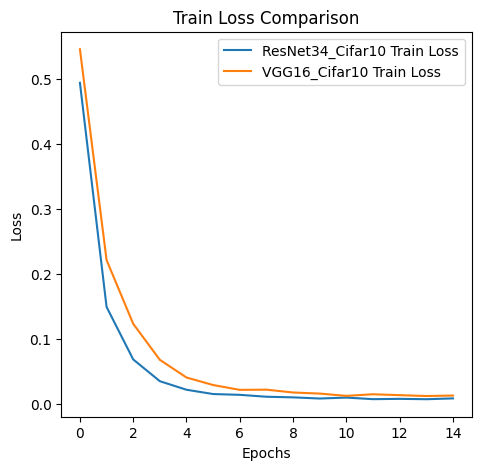

In [ ]:
visualize_history(history_res, history_vgg)

## 4번 문제(미완)



```
# 가상 데이터셋을 생성한 뒤 GridSearch 또는 RandomSearch로 하이퍼 파라미터 조합을 평가하고 조정해보세요
```

